# Data Label Migration
## Project : Logo Detection
## Author : dfd19

Current Project Logo Detection has been created using Custom Vision. We want to export images and its label so we can train our model by ourselves.

----

### Import Library And Initial Variable

In [1]:
%matplotlib inline
import os
import requests
from requests.adapters import HTTPAdapter
from dotenv import load_dotenv
from urllib.parse import urlunsplit, urlencode
from furl import furl
from tqdm.notebook import tqdm
import imghdr
import json
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def build_api_url(base_url, path, param):
    return (
        furl(base_url)
        .set(path=path, args=param)
        .url
    )

def root_path():
    return os.path.abspath(os.sep)

In [2]:
load_dotenv()

projectName = 'LogoDetection'
rootPath = root_path()
datasetDirName = os.path.join(rootPath, 'MachineLearning')
projectDirName = os.path.join(datasetDirName, projectName)
imagesDirName = os.path.join(projectDirName,'images')
bboxDirName = os.path.join(projectDirName,'bbox_txt')
jsonDirName = os.path.join(projectDirName,'meta_json')


CVBaseUrl = os.getenv('CUSTOMVISION_BASEURL')
CVAPIPath = os.getenv('CUSTOMVISION_APIURL')
CVKey = os.getenv('CUSTOMVISION_KEY')
CVGetTaggedImageListPath = [i for i in CVAPIPath.split('/') if i] + ['images', 'tagged']
CVCountTaggedImageListPath = CVGetTaggedImageListPath + ['count']
CVGetTaggedImagePath = "/".join(CVGetTaggedImageListPath)
CVCountTaggedImagePath = "/".join(CVCountTaggedImageListPath)

### Get count images that has been labeled in CustomVision

In [3]:
CVCountTaggedImageAPI = build_api_url(CVBaseUrl,CVCountTaggedImagePath,{})
r = requests.get(CVCountTaggedImageAPI, headers={"Training-key":CVKey})
total_images = r.json()
total_images

813

### Export images and its label to local folder

In [5]:
def exportAllImages(i, step):
    CVGetTaggedImageAPI = build_api_url(CVBaseUrl,CVGetTaggedImagePath,{"orderBy":"Oldest","take":step,"skip":i})
    s = requests.Session()
    s.mount(CVGetTaggedImageAPI, HTTPAdapter(max_retries=5))
    r = s.get(CVGetTaggedImageAPI, headers={"Training-key":CVKey})
    res = r.json()
    for item in tqdm(res, leave=False):
        imgr = requests.get(item["originalImageUri"])
        if imgr.status_code == 200:
            imagetype = imghdr.what(None, imgr.content)
            filename = imgr.url.split("?")[0].split("/")[-1]
            imagename = filename + '.' + imagetype
            jsonname = filename + '.' + 'json'
            with open(os.path.join(imagesDirName, imagename), 'wb') as f:
                f.write(imgr.content)
            with open(os.path.join(jsonDirName, jsonname), 'w') as f:
                json.dump(item, f, indent = 4)
             # This delay is used to prevent connection closed. You can Commented it out or make the delay faster if you want.
            time.sleep(3)

In [6]:
step = 50
res = None
for i in tqdm(range(0, total_images, step)):
    try:
        exportAllImages(i, step)
    except:
        time.sleep(30)
        exportAllImages(i, step)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

### Export Tags into label list

In [12]:
CVGetTagsPath = [i for i in CVAPIPath.split('/') if i] + ['tags']
CVGetTagsAPI = build_api_url(CVBaseUrl, "/".join(CVGetTagsPath) ,{})
r = requests.get(CVGetTagsAPI, headers={"Training-key":CVKey})
res = r.json()
listLabel = [i["name"] for i in res]
with open(os.path.join(projectDirName, 'class_list.txt'), 'w') as fp:
    fp.write("\n".join(str(item) for item in listLabel))

### Test Images And Mapping

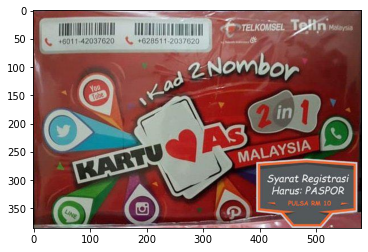

In [13]:
listpathimg = [os.path.join(imagesDirName, i) for i in os.listdir(imagesDirName)]
listpathjson = [os.path.join(jsonDirName, i) for i in os.listdir(jsonDirName)]
image = cv2.imread(listpathimg[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [14]:
image.shape

(385, 581, 3)

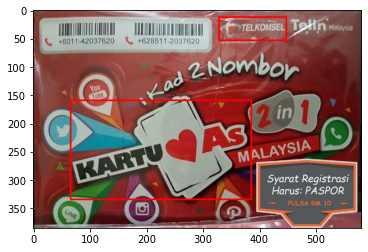

In [21]:
with open(listpathjson[0]) as f:
    jsondata = json.load(f)
    realWidth = image.shape[1]
    realHeight = image.shape[0]
    for region in jsondata["regions"]:
        x1, y1 = int(region["left"]*realWidth) , int(region["top"]*realHeight)
        x2, y2 = int(region["left"]*realWidth + region["width"]*realWidth), int(region["top"]*realHeight + region["height"]*realHeight)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
plt.imshow(image)
plt.show()

### Dictionary Class_list.txt to integer label for yolov5

In [22]:
dictLabel = {listLabel[i]:i for i in range(len(listLabel))}

### Mapping Custom Vision Label to Yolov5 Label

Custom Vision Label boundary box has format like this :
- top : the boundary box of the top in Y-Axis (in ratio)
- left : the boundary box of the left in X-Axis (in ratio)
- width : the size width of boundary box (in ratio)
- height : the size height of boundary box (in ratio)

Meanwhile yolov5 has format like this :
- X : the center X-Axis of the boundary box (in ratio)
- Y : the center Y-Axis of the boundary box (in ratio)
- width : the size width of boundary box (in ratio)
- height : the size height of boundary box (in ratio)

To convert Custom Vision Label to yolov5 format, The Equations are :
- width = width
- height = height
- Y = top + (height/2)
- X = left + (width/2)

In [20]:
for jsonFile in tqdm(os.listdir(jsonDirName)):
    jsonFilePath = os.path.join(jsonDirName, jsonFile)
    fileName = Path(jsonFilePath).stem
    bboxTextFilePath = os.path.join(bboxDirName, fileName + ".txt")
    jsonData = None
    with open(jsonFilePath) as f:
        jsonData = json.load(f)
    regionsData = jsonData["regions"]
    with open(bboxTextFilePath, 'w') as f:
        for region in regionsData:
            y = region["top"] + region["height"]/2
            x = region["left"] + region["width"]/2
            tag = dictLabel[region["tagName"]]
            width = region["width"]
            height = region["height"]
            f.write('{} {} {} {} {}\n'.format(tag, x, y, width, height))

  0%|          | 0/813 [00:00<?, ?it/s]